
## Face Mask Detection

#### Purpose:
Build a model that determines if they are wearing a mask correctly based on pre-trained image data.

#### Input: 
Data set of images (853) with annotations.
#### In files:   
            Images file: Each image can include multiple people
            Annotations file: Contains general information about the image, as well as the coordinates of each face and its label.

#### Data 3 labels:
            With mask: 
            Without mask: 
            Mask worn incorrectly: 

In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [47]:
input_data_path = r'C:\Users\sunfu\OneDrive - Hanoi University of Science and Technology\Facemask\images'
annotations_path = r"C:\Users\sunfu\OneDrive - Hanoi University of Science and Technology\Facemask\annotations"
images = [*os.listdir(r"C:\Users\sunfu\OneDrive - Hanoi University of Science and Technology\Facemask\images")]
# *os.listdir: return the list contains name of the folder in path
output_data_path =  '.'


## Read the annotations file


In [48]:
import xml.etree.ElementTree as ET 
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [49]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

#Output parse_annotation is list of list. Change list to picture
full_dataset = sum(dataset, []) # 

df = pd.DataFrame(full_dataset)
df.shape


(4072, 9)

In [50]:
print('Print 5 data of the head: \n', df.head())

#df.head()

Print 5 data of the head: 
             file  width  height  depth          name  xmin  ymin  xmax  ymax
0  maksssksksss0    512     366      3  without_mask    79   105   109   142
1  maksssksksss0    512     366      3     with_mask   185   100   226   144
2  maksssksksss0    512     366      3  without_mask   325    90   360   141
3  maksssksksss1    400     156      3     with_mask   321    34   354    69
4  maksssksksss1    400     156      3     with_mask   224    38   261    73


### Choose the picture to demo

In [51]:
final_test_image = 'maksssksksss0' # Chọn hình ảnh
# tạo một khung dữ liệu riêng chỉ chứa những người trong hình ảnh cụ thể này
df_final_test = df.loc[df["file"] == final_test_image] 
# xóa hình ảnh khỏi bộ dữ liệu đầy đủ
images.remove(f'{final_test_image}.png')
# xóa thông tin của hình ảnh khỏi bộ dữ liệu đầy đủ
df = df.loc[df["file"] != final_test_image] 


In [52]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141


### Change name Column



In [53]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

### Chart of data

In [54]:
df["label"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Label')

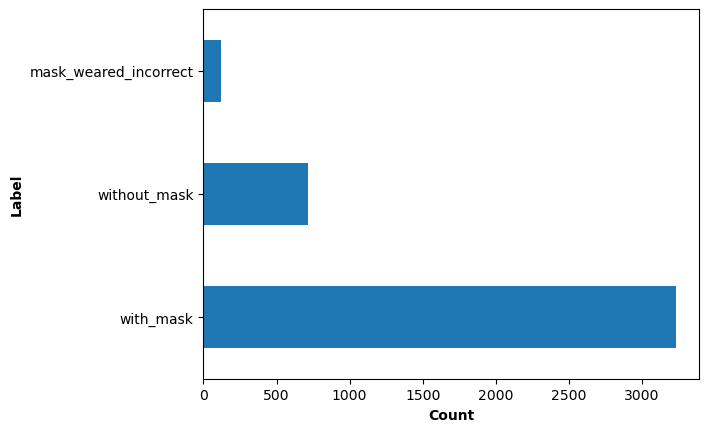

In [55]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

## Data


In [56]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

Augment for x and y coordinates of two oppsite

In [57]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle 
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

Crop faces in each picture

In [58]:
def extract_faces(image_name, image_info):
    
    '''
     Hàm này lấy tên hình ảnh + khung dữ liệu với thông tin về hình ảnh
     và chia hình ảnh thành tất cả các khuôn mặt khác nhau. tên hình ảnh có chứa
     tọa độ phía trên bên trái của mỗi khuôn mặt để chúng ta có thể phân biệt nó sau này
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

Use`extract_faces` in the data

In [59]:
cropped_faces = [extract_faces(img, df) for img in images]

KeyboardInterrupt: 

Change list to picture

In [ ]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

# Arrange the images into their labels in 3 layers.

In [ ]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

Check

In [ ]:
print(f'Size of face with mask: {len(with_mask)}')
print(f'Size of face without mask: {len(without_mask)}')
print(f'Size of face mask weard incorrect: {len(mask_weared_incorrect)}')
print(f'Summary: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

Size of face with mask: 3224
Size of face without mask: 716
Size of face mask weard incorrect: 123
Summary: 4063


# **Chia tập dữ liệu đầy đủ thành các train (80%) và test (20%). Bộ kiểm tra được chia lại thành bộ kiểm tra (30%) và xác thực (70%). **

In [ ]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [ ]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     
Hàm này lấy tên hình ảnh + đường dẫn của thư mục đầu ra
     và lưu hình ảnh vào thư mục đầu ra
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)   

Save picture 

In [ ]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


# Model CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

###Plotting the model architecture

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Define the constrain

In [ ]:
batch_size = 8
epochs = 50

Để nâng cao hiệu suất mô hình, tôi muốn thêm nhiều dữ liệu hơn để đào tạo. Nhóm sẽ sử dụng phép tăng cường dữ liệu để tạo thêm các mẫu dữ liệu một cách giả tạo.

Để làm điều đó, tôi sẽ sử dụng Keras `ImageDataGenerator`. Công cụ này cho phép tôi tạo các hình ảnh đào tạo mới bằng cách thao tác với các hình ảnh thoát (chia tỷ lệ, xoay, lật, v.v.). Tuy nhiên, vì không phải tất cả các thao tác đều có ý nghĩa trong ngữ cảnh của hình ảnh khuôn mặt, tức là lật mặt theo chiều dọc không phải là tùy chọn hợp lệ đối với một người đang đi bộ trên phố, tôi sẽ chỉ sử dụng một tập hợp con nhỏ các thao tác có thể.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='test',  
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3816 images belonging to 3 classes.
Found 1017 images belonging to 3 classes.
Found 453 images belonging to 3 classes.


In [ ]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 59
val_steps: 16


In [ ]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)
#model.optimizer.lr=0.001

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

## Reduce the learning rate on the plateau
Chúng tôi xác định lệnh gọi lại `ReduceLROnPlateau` để giảm tốc độ học tập khi số liệu chúng tôi chọn (`val_loss`) đã ngừng cải thiện.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)


In [ ]:
# Fit the model on train data

model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

C:\Users\sunfu\AppData\Local\Temp\ipykernel_2280\2332504450.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/50
59/59 [==============================] - 14s 158ms/step - loss: 0.5913 - accuracy: 0.7860 - recall: 0.7797 - precision: 0.8124 - auc: 0.9060 - val_loss: 0.3863 - val_accuracy: 0.8359 - val_recall: 0.8125 - val_precision: 0.8814 - val_auc: 0.9681 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 6s 101ms/step - loss: 0.3480 - accuracy: 0.8835 - recall: 0.8623 - precision: 0.8965 - auc: 0.9671 - val_loss: 0.3151 - val_accuracy: 0.9062 - val_recall: 0.8984 - val_precision: 0.9127 - val_auc: 0.9720 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 4s 74ms/step - loss: 0.2639 - accuracy: 0.9258 - recall: 0.9174 - precision: 0.9393 - auc: 0.9794 - val_loss: 0.2790 - val_accuracy: 0.9062 - val_recall: 0.8828 - val_precision: 0.9339 - val_auc: 0.9798 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 3s 57ms/step - loss: 0.1988 - accuracy: 0.9470 - recall: 0.9428 - precision: 0.9570 - auc: 0.9869 - val_loss: 0.3976 - val_accuracy: 0.8828 -

In [ ]:
# Đánh giá hiệu suất mô hình trên dữ liệu thử nghiệm
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (recall*100, precision*100, auc*100))

57/57 [==============================] - 2s 28ms/step - loss: 0.1532 - accuracy: 0.9558 - recall: 0.9514 - precision: 0.9578 - auc: 0.9937
Model has a loss of 0.15 and accuracy 95.58%
Model has a recall of 95.14%, precision of 95.78% and auc of 99.37%


In [ ]:
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

57/57 [==============================] - 1s 7ms/step
predictions shape: (453, 3)


In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')


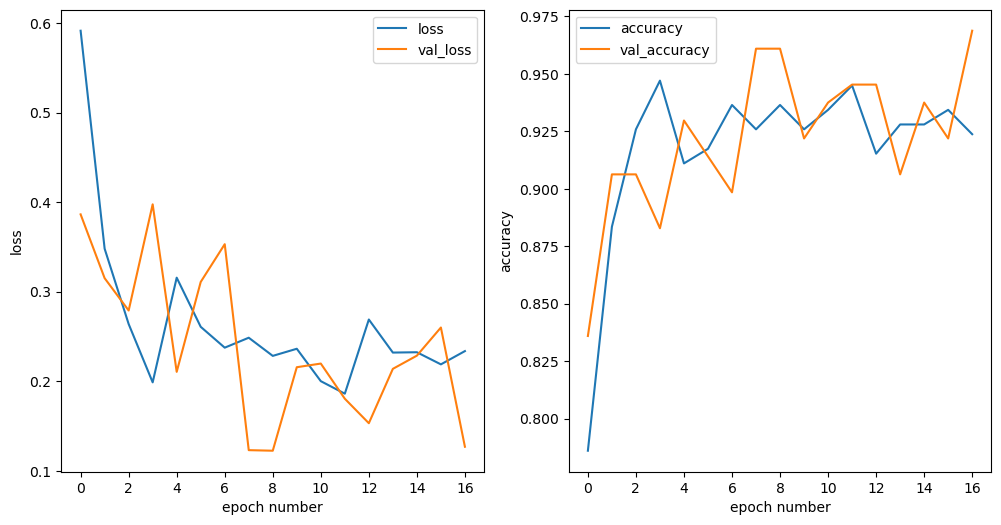

In [ ]:
plot_loss_and_accuracy(model_history.history)

### Test

57/57 [==============================] - 0s 8ms/step
Class Predicted: with_mask , True label: with_mask\maksssksksss622_(322, 76).png


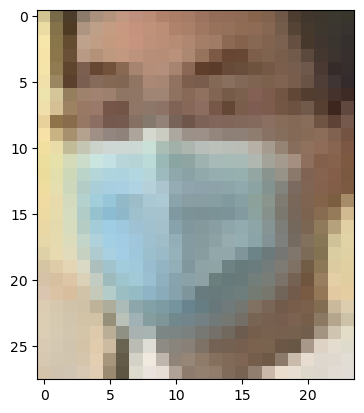

In [ ]:
import cv2

paths = test_generator.filenames # Your files path

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

57/57 [==============================] - 0s 8ms/step


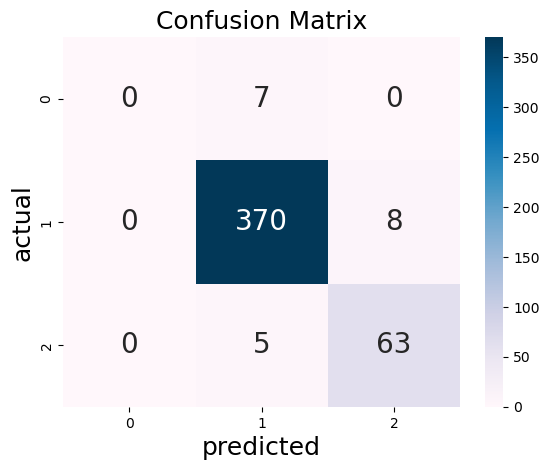

In [ ]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [ ]:
classes

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [ ]:
np.bincount(y_pred) # Use bincount() to count occurrences of each class in a predictions NumPy array

array([  0, 382,  71], dtype=int64)

# Demo

1/1 [==============================] - 0s 35ms/step


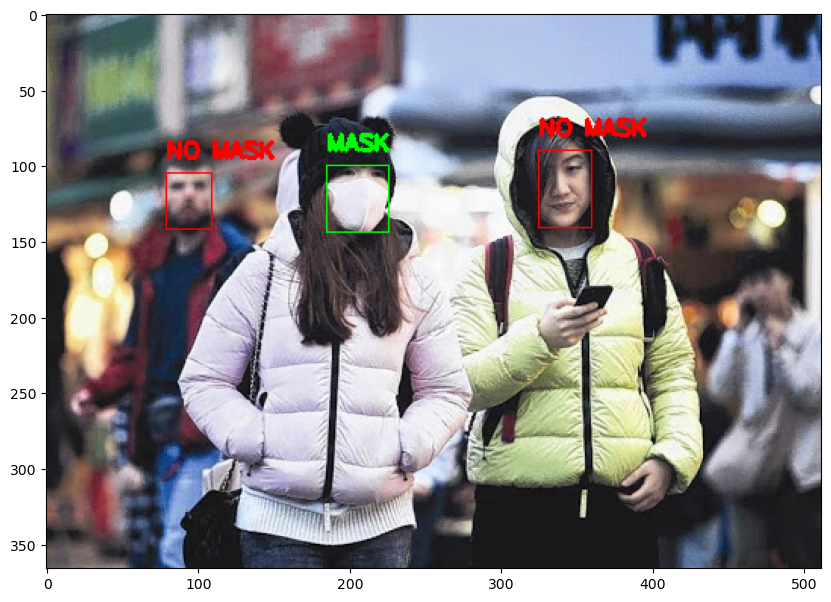

In [60]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)


## Proposal to improve the model

1. Collect more pictures of people wearing masks incorrectly, because even though wearing a mask incorrectly is the same as not wearing a mask, the model classifies it as wearing a mask.

2. Use transfer learning with a pre-trained model such as VGG19 (we have to collect more data first).